# Torob Project: Product Category Classification Based On Images

Hi and welcome to Torob hands-on project for OpenAI machine learning bootcamp 2023! 👋 🎉

In this project, you will use the real images of a very small subset of products in Torob product catalogue for the task of "product category classification". Given a set of product images from 10 different categories, you should build a classifier model which given a product image, it would predict the category of the product.

**Note that the sections which you need to complete or write your answers are marked with 🔵 (a blue circle).**

There is also a Persian guide for this project which you can access here: https://docs.google.com/document/d/1FiWXlNUo44U1ECRG7OSKJXsC_WjMjcMSPfz7lMhbYzo/edit?usp=sharing

So, let's get started!

## ⭕ Install dependencies

▶ Since we are going to work with HuggingFace Transformers library, it needs to be installed. Further, the `gdown` and `datasets` packages are also installed which are used for downloading the data from Google Drive and loading and reading the data, respectively.

In [1]:
!pip install -q -U datasets gdown transformers

▶ And then we import the necessary libraries and modules:

In [2]:
import random
from datasets import load_dataset
from transformers import AutoImageProcessor, ResNetModel
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.models import resnet101, resnet18
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score

## ⭕ Download Data

▶ As the first step, we need to download the data of product images. For your convenience, it has been uploaded as a zip file on the Google Drive and can be downloaded using `gdown` command. Just run the following cell to download the data.

In [3]:
!gdown 1DM8cKZFFU1z5fN7h34l3Ji6h5UytYMpb

Downloading...
From (uriginal): https://drive.google.com/uc?id=1DM8cKZFFU1z5fN7h34l3Ji6h5UytYMpb
From (redirected): https://drive.google.com/uc?id=1DM8cKZFFU1z5fN7h34l3Ji6h5UytYMpb&confirm=t&uuid=0d8cb78e-29f2-40b9-aa5c-8697917266e7
To: /content/torob-product-images.zip
100% 445M/445M [00:13<00:00, 34.1MB/s]


## ⭕ Load Data

▶ Next, we should load the image data. The structure of the data is as follows:

```
torob-product-images
    fryer
        1.jpg
        2.jpg
        ...
    graphic-card
        1.jpg
        2.jpg
        ...
    ...
```
▶ The images for each category is in a seperate directory. We use the `load_dataset` function from HuggingFace `dataset` library to load all the images, and use the name of each directory as the label of the images.

In [ ]:
dataset = load_dataset("imagefolder", data_files="./torob-product-images.zip", split='train')

▶ Let's inspect the labels of the images to see the title of the 10 categories:

In [5]:
dataset.features['label'].names

['fryer',
 'graphic-card',
 'mens-boots',
 'mens-sandals',
 'mens-sport-shoes',
 'microwave',
 'mobile',
 'motherboard',
 'tablet',
 'toaster']

▶ Further, note that the images can be accessed via `"images"` column of the dataset (i.e. `dataset["images"]`) and their corresponding labels can be accessed using `"label"` column (i.e. `dataset["label"]`).

▶ Let's randomly select a few images and display them (the resized images are displayed here, because some of them may be big).

Label of following image: mobile


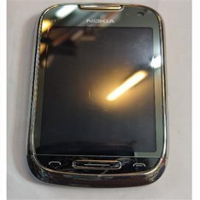

Label of following image: mens-sandals


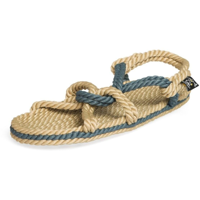

Label of following image: tablet


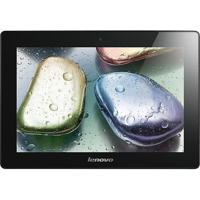

Label of following image: microwave


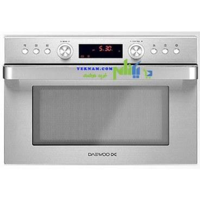

Label of following image: microwave


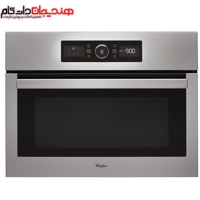

Label of following image: motherboard


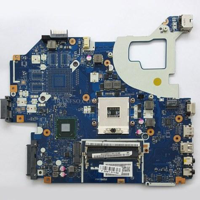

Label of following image: mens-sandals


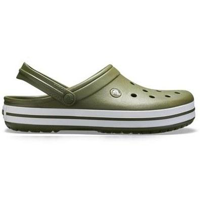

Label of following image: tablet


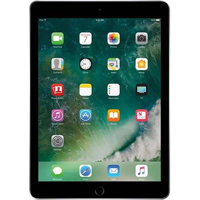

Label of following image: fryer


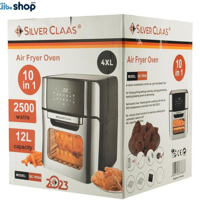

Label of following image: mobile


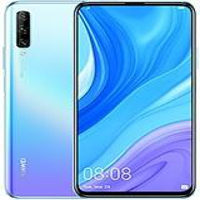

In [6]:
sampled_idx = random.sample(range(len(dataset)), k=10)
sampled_data = dataset.select(sampled_idx)
for img, lbl in zip(sampled_data["image"], sampled_data["label"]):
  print("Label of following image:", dataset.features['label'].names[lbl])
  display(img.resize((200, 200)))
  print("="*80)

## ⭕ Train-Test Split

▶ We need to split our data into train and test set so that we can evaluate the performance of different classifiers on unseen data. We use a 80/20 split (80% for train, 20% for test).

🔵 To split the dataset, we can use `train_test_split` method (it's very similar to `train_test_split` function in `sklearn` library). Replace the `???` in the following cell.

In [7]:
splited_dataset = dataset.train_test_split(test_size=0.2, stratify_by_column='label', shuffle=True, seed=42)
train_dataset = splited_dataset["train"]
test_dataset = splited_dataset["test"]

## ⭕ Simple Features Extraction

▶ The first method we use for feature extraction is very simple: for each image, the **average** (mean) and **standard deviation** (std) of pixels of each channel (R, G & B) is calculated, and together they are used to represent that image. In other words, each image would be represented by only 6 (3 for average + 3 for standard deviation) numbers.

🔵 We have defined a function named `calculate_simple_features` but it's not complete. It operates on single example of the dataset to calculate the features mentioned above and stores the features in the key `"simple_features"`. Use `numpy` library (imported as `np`) to calculate the average and standard deviation of each image. Replace all the `???` to complete the implementation.

In [29]:
def calculate_simple_features(example):
  img_mean = np.mean(example["image"], axis=(0, 1))
  img_std = np.std(example["image"], axis=(0, 1))
  example["simple_features"] = np.concatenate((img_mean, img_std), axis=-1)
  return example

🔵 Now, use `map` method of the dataset to apply the above function on each example in the train and test datasets. Replace `???` with your answers.

In [ ]:
train_dataset = train_dataset.map(calculate_simple_features)
test_dataset = test_dataset.map(calculate_simple_features)

▶ Make sure we have correctly implemented the feature extraction step. We should see "Well done!" printed without any errors.

In [31]:
assert len(train_dataset["simple_features"][0]) == 6
assert len(test_dataset["simple_features"][0]) == 6
print("Well done!")

Well done!


## ⭕ Train and Evaluate Models on Simple Features

▶ Now, it's time to train and evaluate some models on the extracted features. We try three different classifiers: KNN, Decision Tree, and Random Forest.

### 🔵 KNN Classifier

Train a **KNN** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_neighbors`, and tune them (but it's not necessary).

**Hint:** Remember that the features are stored in `"simple_features"` column of the dataset (i.e. `train_dataset["simple_features"]`), and the labels are stored in `"label"` column.

In [32]:
X_train = train_dataset["simple_features"]
Y_train =  train_dataset["label"]
X_test =  train_dataset["simple_features"]
Y_test =  train_dataset["label"]

In [68]:
k_values = [3, 5, 7]
knn_scores = {}

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train, Y_train)

    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    knn_scores[k] = {'Accuracy': accuracy}


🔵 Now, find the accuracy of trained classifier on the test data.

**Hint:** You can use `score` method. and make a dataframe

In [69]:
knn_data = []
for k, scores in knn_scores.items():
    knn_data.append({'feature_extraction_method': 'simple features', 'model': 'KNN','parameters': k, 'accuracy': scores['Accuracy']})
    knn_df_simple = pd.DataFrame(knn_data)
    print(f"K = {k}:")
    print("Accuracy:", scores['Accuracy'])
    print()


K = 3:
Accuracy: 0.3915

K = 5:
Accuracy: 0.391

K = 7:
Accuracy: 0.397



### 🔵 Decision Tree Classifier

Next, we train a **decision tree** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `max_depth`, and tune them (but it's not necessary).

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

max_depths = [3, 5, 7]
dt_scores = {}

for depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth)

    dt_classifier.fit(X_train, Y_train)

    Y_pred = dt_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    dt_scores[depth] = {'Accuracy': accuracy}



🔵 Like before, we would like to find the accuracy of trained classifier on the test data.

**Hint:** Still you can use `score` method!

In [71]:
dt_data = []
for depth, scores in dt_scores.items():
    dt_data.append({'feature_extraction_method': 'simple features', 'model': 'DecisionTree','parameters': depth, 'accuracy': scores['Accuracy']})
    dt_df_simple = pd.DataFrame(dt_data)
    print(f"Max Depth = {depth}:")
    print("Accuracy:", scores['Accuracy'])
    print()

Max Depth = 3:
Accuracy: 0.253

Max Depth = 5:
Accuracy: 0.308

Max Depth = 7:
Accuracy: 0.3465



### 🔵 Random Forest Classifier

And another classifier: we train a **random forest** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_estimators`, and tune them (but it's not necessary).

In [72]:
n_estimators = [100, 200, 300]
rf_scores = {}

for n in n_estimators:
    rf_classifier = RandomForestClassifier(n_estimators=n)

    rf_classifier.fit(X_train, Y_train)

    Y_pred = rf_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    rf_scores[n] = {'Accuracy': accuracy}

🔵 And again we need to find the accuracy of trained classifier on the test data.

# Show the Score

In [76]:
rf_data = []
for n, scores in rf_scores.items():
    rf_data.append({'feature_extraction_method': 'simple features', 'model': 'Random Forest ','parameters': n, 'accuracy': scores['Accuracy']})
    rf_df_simple = pd.DataFrame(rf_data)
    print(f"n_estimators = {n}:")
    print("Accuracy:", scores['Accuracy'])
    print()

n_estimators = 100:
Accuracy: 0.486

n_estimators = 200:
Accuracy: 0.494

n_estimators = 300:
Accuracy: 0.496



 # Concatenate all df to one

In [77]:
simple_features_df = pd.concat([knn_df_simple, dt_df_simple, rf_df_simple])


In [78]:
simple_features_df

,feature_extraction_method,model,parameters,accuracy
0,simple features,KNN,3,0.3915
1,simple features,KNN,5,0.3910
2,simple features,KNN,7,0.3970
0,simple features,DecisionTree,3,0.2530
1,simple features,DecisionTree,5,0.3080
2,simple features,DecisionTree,7,0.3465
0,simple features,Random Forest,100,0.4860
1,simple features,Random Forest,200,0.4940
2,simple features,Random Forest,300,0.4960


## ⭕ Histogram Features Extraction

▶ The second method we use for feature extraction is more complex than the first method: for each image, the histogram of pixel values is calculated, and this histogram is used to represent that image. In other words, each image would be represented by *b* numbers, where *b* is the number of bins in the histogram. We expect this method to peform better than the previous method of feature extraction.

🔵 We have defined a function named `calculate_histogram_features` but it's not complete. It operates on single example of the dataset to calculate the histogram of the image and store it in the column `"histogram_features"`. Use `numpy` library (imported as `np`) to calculate the histogram of each image. Replace all the `???` to complete the implementation.

In [59]:
def calculate_histogram_features(example, n_bins=16):
  img_hist, _ = np.histogram(example["image"], bins=n_bins, range=(0, 255))
  # We normalize the histogram values so it would be independent of the size of image.
  img_hist = img_hist / img_hist.sum()
  example["histogram_features"] = img_hist
  return example

🔵 Now, use the above function and apply it on train and test images using `map` method to calculate their histogram features. Replace `???` with your answers.

In [ ]:
train_dataset = train_dataset.map(calculate_histogram_features)
test_dataset = test_dataset.map(calculate_histogram_features)

▶ Make sure we have correctly implemented the feature extraction step. We should see "Well done!" printed without any errors.

In [43]:
assert len(train_dataset["histogram_features"][0]) == 16
assert len(test_dataset["histogram_features"][0]) == 16
print("Well done!")

Well done!


## ⭕ Train and Evaluate Models on Histogram Features

▶ Like the simple features, we would like to evaluate the performance of the models using histogram features we just calculated.

### 🔵 KNN Classifier

Train a **KNN** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_neighbors`, and tune them (but it's not necessary).

In [60]:
X_train = train_dataset["histogram_features"]
Y_train = train_dataset["label"]
X_test = test_dataset["histogram_features"]
Y_test = test_dataset["label"]

In [45]:
k_values = [3, 5, 7]
knn_scores = {}

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train, Y_train)

    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    knn_scores[k] = {'Accuracy': accuracy}


🔵 Now, find the accuracy of trained classifier on the test data.

**Hint:** You can use `score` method.

In [46]:
knn_data = []
for k, scores in knn_scores.items():
    knn_data.append({'feature_extraction_method': 'Histogram Features', 'model': 'KNN','parameters': k, 'accuracy': scores['Accuracy']})
    knn_df_hist = pd.DataFrame(knn_data)
    print(f"K = {k}:")
    print("Accuracy:", scores['Accuracy'])
    print()


K = 3:
Accuracy: 0.3915

K = 5:
Accuracy: 0.391

K = 7:
Accuracy: 0.397



### 🔵 Decision Tree Classifier

Next, we train a **decision tree** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `max_depth`, and tune them (but it's not necessary).

In [61]:
max_depths = [3, 5, 7]
dt_scores = {}

for depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth)

    dt_classifier.fit(X_train, Y_train)

    Y_pred = dt_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    dt_scores[depth] = {'Accuracy': accuracy}

🔵 Like before, we would like to find the accuracy of trained classifier on the test data.

**Hint:** Still you can use `score` method!

In [62]:
dt_data = []
for depth, scores in dt_scores.items():
    dt_data.append({'feature_extraction_method': 'Histogram Features', 'model': 'DecisionTree','parameters': depth, 'accuracy': scores['Accuracy']})
    dt_df_hist = pd.DataFrame(dt_data)
    print(f"Max Depth = {depth}:")
    print("Accuracy:", scores['Accuracy'])
    print()

Max Depth = 3:
Accuracy: 0.253

Max Depth = 5:
Accuracy: 0.308

Max Depth = 7:
Accuracy: 0.346



### 🔵 Random Forest Classifier

And another classifier: we train a **random forest** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_estimators`, and tune them (but it's not necessary).

In [49]:
n_estimators = [100, 200, 300]
rf_scores = {}

for n in n_estimators:
    rf_classifier = RandomForestClassifier(n_estimators=n)

    rf_classifier.fit(X_train, Y_train)

    Y_pred = rf_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    rf_scores[n] = {'Accuracy': accuracy}

🔵 And again we need to find the accuracy of trained classifier on the test data.

In [50]:
rf_data = []
for n, scores in rf_scores.items():
    rf_data.append({'feature_extraction_method': 'Histogram Features', 'model': 'Random Forest ','parameters': n, 'accuracy': scores['Accuracy']})
    rf_df_hist = pd.DataFrame(rf_data)
    print(f"n_estimators = {n}:")
    print("Accuracy:", scores['Accuracy'])
    print()

n_estimators = 100:
Accuracy: 0.4885

n_estimators = 200:
Accuracy: 0.502

n_estimators = 300:
Accuracy: 0.4995



 # Concatenate all df to one

In [51]:
hist_features_df = pd.concat([knn_df_hist, dt_df_hist, rf_df_hist])

In [52]:
hist_features_df

,feature_extraction_method,model,parameters,accuracy
0,Histogram Features,KNN,3,0.3915
1,Histogram Features,KNN,5,0.3910
2,Histogram Features,KNN,7,0.3970
0,Histogram Features,DecisionTree,3,0.2530
1,Histogram Features,DecisionTree,5,0.3080
2,Histogram Features,DecisionTree,7,0.3455
0,Histogram Features,Random Forest,100,0.4885
1,Histogram Features,Random Forest,200,0.5020
2,Histogram Features,Random Forest,300,0.4995


## ⭕ Pretrained Model (ResNet) Features Extraction

▶ The third and final method we use for feature extraction is based on using a pretrained CNN (Convolutional Neural Network): for each image, we use a pretrained ResNet model to extract its features. In other words, each image would be represented by the features of the last layer of the ResNet model which is equal to 2048 numbers.

🔵 We use the HuggingFace Transformers library to download and load the preprocessor as well as the model weights of the **ResNet-50** model which has been already trained on ImageNet dataset. Replace all the `???` to download and load the pretrained preprocessors and model.

In [12]:
resnet50_img_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
resnet50_model = ResNetModel.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


▶ Next, we define a function to apply these two operations on a batch of images:

- Use the ResNet preprocessor to preprocess the images (e.g. resize, normalizing the pixel values, etc.) so that they are ready to be fed to the ResNet model,
- Apply the ResNet model on the preprocessed images to extract their features. As you can see, we use the output of last "pooler layer" as the features.

🔵 Use ResNet preprocessor and model to extract features from the images. For that, you need to complete the implementation of the following function. Replace all the `???` with your answers.

In [9]:
def calculate_resnet_features(examples):
  inputs = resnet50_img_processor(examples["image"], return_tensors="pt")
  with torch.no_grad():
    features = resnet50_model(**inputs).pooler_output.squeeze().numpy()
  examples["resnet50_features"] = features
  return examples

🔵 Now, use the above function and apply it on train and test images using `map` method of dataset to extract features using ResNet model. Replace `???` with your answers.

In [ ]:
train_dataset = train_dataset.map(calculate_resnet_features, batched=True, batch_size=64)
test_dataset = test_dataset.map(calculate_resnet_features, batched=True, batch_size=64)


# making sure that create a new column as 'resnet50_features' in dataset

In [11]:
assert len(train_dataset[0]["resnet50_features"]) == 2048
assert len(test_dataset[0]["resnet50_features"]) == 2048
print("well done")

well done


## ⭕ Train and Evaluate Models on ResNet Features

▶ Now that we have extracted features using ResNet model, we can train and evaluated a classifier on these features. **We expect these features to perform much better than the two previous methods for extracting features and that's due to the power of pretrained features and transfer learning.**

### 🔵 KNN Classifier

Train a **KNN** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_neighbors`, and tune them (but it's not necessary).

In [13]:
X_train = train_dataset["resnet50_features"]
Y_train = train_dataset["label"]
X_test = test_dataset["resnet50_features"]
Y_test = test_dataset["label"]

In [14]:
k_values = [3, 5, 7]
knn_scores = {}

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train, Y_train)

    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    knn_scores[k] = {'Accuracy': accuracy}

🔵 Now, find the accuracy of trained classifier on the test data.

**Hint:** You can use `score` method.

In [15]:
knn_data = []
for k, scores in knn_scores.items():
    knn_data.append({'feature_extraction_method': 'resnet50 Features', 'model': 'KNN','parameters': k, 'accuracy': scores['Accuracy']})
    knn_df_rn50 = pd.DataFrame(knn_data)
    print(f"K = {k}:")
    print("Accuracy:", scores['Accuracy'])
    print()

K = 3:
Accuracy: 0.915

K = 5:
Accuracy: 0.9145

K = 7:
Accuracy: 0.91



### 🔵 Decision Tree Classifier

Next, we train a **decision tree** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `max_depth`, and tune them (but it's not necessary).

In [16]:
max_depths = [3, 5, 7]
dt_scores = {}

for depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth)

    dt_classifier.fit(X_train, Y_train)

    Y_pred = dt_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    dt_scores[depth] = {'Accuracy': accuracy}

🔵 Like before, we would like to find the accuracy of trained classifier on the test data.

**Hint:** Still you can use `score` method!

In [17]:
dt_data = []
for depth, scores in dt_scores.items():
    dt_data.append({'feature_extraction_method': 'resnet50 Features', 'model': 'DecisionTree','parameters': depth, 'accuracy': scores['Accuracy']})
    dt_df_rn50 = pd.DataFrame(dt_data)
    print(f"Max Depth = {depth}:")
    print("Accuracy:", scores['Accuracy'])
    print()

Max Depth = 3:
Accuracy: 0.4855

Max Depth = 5:
Accuracy: 0.6705

Max Depth = 7:
Accuracy: 0.7845



### 🔵 Random Forest Classifier

And another classifier: we train a **random forest** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_estimators`, and tune them (but it's not necessary).

In [18]:
n_estimators = [100, 200, 300]
rf_scores = {}

for n in n_estimators:
    rf_classifier = RandomForestClassifier(n_estimators=n)

    rf_classifier.fit(X_train, Y_train)

    Y_pred = rf_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    rf_scores[n] = {'Accuracy': accuracy}

🔵 And again we need to find the accuracy of trained classifier on the test data.

In [19]:
rf_data = []
for n, scores in rf_scores.items():
    rf_data.append({'feature_extraction_method': 'resnet50 Features', 'model': 'Random Forest ','parameters': n, 'accuracy': scores['Accuracy']})
    rf_df_rn50 = pd.DataFrame(rf_data)
    print(f"n_estimators = {n}:")
    print("Accuracy:", scores['Accuracy'])
    print()

n_estimators = 100:
Accuracy: 0.9105

n_estimators = 200:
Accuracy: 0.9085

n_estimators = 300:
Accuracy: 0.9105



 # Concatenate all df to one

In [54]:
rn50_features_df = pd.concat([knn_df_rn50, dt_df_rn50, rf_df_rn50])

In [21]:
rn50_features_df

,feature_extraction_method,model,parameters,accuracy
0,resnet50 Features,KNN,3,0.9150
1,resnet50 Features,KNN,5,0.9145
2,resnet50 Features,KNN,7,0.9100
0,resnet50 Features,DecisionTree,3,0.4855
1,resnet50 Features,DecisionTree,5,0.6705
2,resnet50 Features,DecisionTree,7,0.7845
0,resnet50 Features,Random Forest,100,0.9105
1,resnet50 Features,Random Forest,200,0.9085
2,resnet50 Features,Random Forest,300,0.9105


In [55]:
all_features_df = pd.concat([simple_features_df, hist_features_df, rn50_features_df])
all_features_df

,feature_extraction_method,model,parameters,accuracy
0,simple features,KNN,3,0.585750
1,simple features,KNN,5,0.528000
2,simple features,KNN,7,0.487375
0,simple features,DecisionTree,3,0.219750
1,simple features,DecisionTree,5,0.281000
2,simple features,DecisionTree,7,0.345875
0,simple features,Random Forest,100,0.998625
1,simple features,Random Forest,200,0.998625
2,simple features,Random Forest,300,0.998625
0,Histogram Features,KNN,3,0.391500


## 🔵 Open Tasks

Now, here are some more tasks which you need to answer:

1. Implement a different method for extracting features from an image. And then compare its performance with the methods you tried above.

2. Use another classifier besides the three classifiers mentioned above. Can you find a more powerful classifier?

3. The ResNet is actually a family of models [with different sizes](https://huggingface.co/models?sort=downloads&search=microsoft%2Fresnet-) (e.g. `resnet-50`, `resnet-18`, `resnet-101`) , and its bigger models usually have a higher performance. Use a bigger version of ResNet model (using Transformers library as above) and see if it can improve the performance of classification.

4. Create a table which contains the performance of various models as well as different feature extraction methods you have tried in this notebook. Optionally, you can create it as a Pandas Dataframe using the `pandas` library.

Congratulations for reaching so far! 👏 We hope you have enjoyed doing this project and learned many things. 🎉 Good luck and have fun! 🙌

In [ ]:
def calculate_color_histograms(example, n_bins=16):
  image = np.array(example["image"])
  red_hist, _ = np.histogram(image[:, :, 0], bins=n_bins, range=(0, 255))
  green_hist, _ = np.histogram(image[:, :, 1], bins=n_bins, range=(0, 255))
  blue_hist, _ = np.histogram(image[:, :, 2], bins=n_bins, range=(0, 255))
  color_histograms = np.concatenate((red_hist, green_hist, blue_hist))
  example["color_histograms"] = color_histograms
  return example


In [ ]:
train_dataset = train_dataset.map(calculate_color_histograms)
test_dataset = test_dataset.map(calculate_color_histograms)

In [ ]:
assert "color_histograms" in train_dataset.column_names
assert "color_histograms" in test_dataset.column_names

print("Well done!")

Well done!


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors_values = [3, 5, 7]  
knn_classifiers = []  

X_train = train_dataset["color_histograms"]
y_train = train_dataset["label"]
X_test = test_dataset["color_histograms"]
y_test = test_dataset["label"]

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train, Y_train)

    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    knn_scores[k] = {'Accuracy': accuracy}


In [ ]:
knn_data = []
for k, scores in knn_scores.items():
    knn_data.append({'feature_extraction_method': 'color_histograms Features', 'model': 'KNN','parameters': k, 'accuracy': scores['Accuracy']})
    knn_df_ch = pd.DataFrame(knn_data)
    print(f"K = {k}:")
    print("Accuracy:", scores['Accuracy'])
    print()

K:3, score:0.338
K:5, score:0.3525
K:7, score:0.353


In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def calculate_lbp_features(example, radius=1, n_points=8):
  image = np.array(example["image"])  # Convert JpegImageFile to NumPy array
  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
  lbp_features = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))[0]
  example["lbp_features"] = lbp_features
  return example


In [ ]:
train_dataset = train_dataset.map(calculate_lbp_features)
test_dataset = test_dataset.map(calculate_lbp_features)

In [ ]:
assert "lbp_features" in train_dataset.column_names
assert "lbp_features" in test_dataset.column_names

print("Well done!")

Well done!


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train = train_dataset["lbp_features"]
y_train = train_dataset["label"]
X_test = test_dataset["lbp_features"]
y_test = test_dataset["label"]

k_values = [3, 5, 7]
knn_scores = {}

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train, Y_train)

    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    knn_scores[k] = {'Accuracy': accuracy}


In [ ]:
knn_data = []
for k, scores in knn_scores.items():
    knn_data.append({'feature_extraction_method': 'lbp Features', 'model': 'KNN','parameters': k, 'accuracy': scores['Accuracy']})
    knn_df_lbp = pd.DataFrame(knn_data)
    print(f"K = {k}:")
    print("Accuracy:", scores['Accuracy'])
    print()

K:3, score:0.351
K:5, score:0.362
K:7, score:0.3635


# Using Restnet 18

In [ ]:
resnet18_model = resnet18(pretrained=True)

def calculate_resnet18_features(example):
  image = example["image"]
  tensor_image = ToTensor()(image)
  inputs = tensor_image.unsqueeze(0)
  with torch.no_grad():
    features = resnet18_model(inputs).squeeze().numpy()
  example["resnet18_features"] = features
  return example

In [ ]:
train_dataset = train_dataset.map(calculate_resnet18_features)
test_dataset = test_dataset.map(calculate_resnet18_features)

In [ ]:
assert "resnet18_features" in train_dataset.column_names
assert "resnet18_features" in test_dataset.column_names

print("Well done!")

# Knn Classifier for resnet18

In [ ]:
X_train = train_dataset["resnet18_features"]
y_train = train_dataset["label"]
X_test = test_dataset["resnet18_features"]
y_test = test_dataset["label"]

k_values = [3, 5, 7]
knn_scores = {}

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train, Y_train)

    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    knn_scores[k] = {'Accuracy': accuracy}

In [ ]:
knn_data = []
for k, scores in knn_scores.items():
    knn_data.append({'feature_extraction_method': 'resnet18 Features', 'model': 'KNN','parameters': k, 'accuracy': scores['Accuracy']})
    knn_df_rn18 = pd.DataFrame(knn_data)
    print(f"K = {k}:")
    print("Accuracy:", scores['Accuracy'])
    print()

# DecisionTreeClassifier for resnet18

In [ ]:
max_depths = [3, 5, 7]
dt_scores = {}

for depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth)

    dt_classifier.fit(X_train, Y_train)

    Y_pred = dt_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    dt_scores[depth] = {'Accuracy': accuracy}

In [ ]:
dt_data = []
for depth, scores in dt_scores.items():
    dt_data.append({'feature_extraction_method': 'resnet18 Features', 'model': 'DecisionTree','parameters': depth, 'accuracy': scores['Accuracy']})
    dt_df_rn18 = pd.DataFrame(dt_data)
    print(f"Max Depth = {depth}:")
    print("Accuracy:", scores['Accuracy'])
    print()

# RandomForest for resnet18

In [ ]:
n_estimators = [100, 200, 300]
rf_scores = {}

for n in n_estimators:
    rf_classifier = RandomForestClassifier(n_estimators=n)

    rf_classifier.fit(X_train, Y_train)

    Y_pred = rf_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    rf_scores[n] = {'Accuracy': accuracy}

In [ ]:
rf_data = []
for n, scores in rf_scores.items():
    rf_data.append({'feature_extraction_method': 'resnet18 Features', 'model': 'Random Forest ','parameters': n, 'accuracy': scores['Accuracy']})
    rf_df_rn18 = pd.DataFrame(rf_data)
    print(f"n_estimators = {n}:")
    print("Accuracy:", scores['Accuracy'])
    print()

# Using Restnet 101

In [8]:
resnet101_model = resnet101(pretrained=True)

def calculate_resnet101_features(example):
  image = example["image"]
  tensor_image = ToTensor()(image)
  inputs = tensor_image.unsqueeze(0)
  with torch.no_grad():
    features = resnet101_model(inputs).squeeze().numpy()
  example["resnet101_features"] = features
  return example

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:05<00:00, 32.5MB/s]


In [ ]:
train_dataset = train_dataset.map(calculate_resnet101_features)
test_dataset = test_dataset.map(calculate_resnet101_features)

In [ ]:
assert "resnet101_features" in train_dataset.column_names
assert "resnet101_features" in test_dataset.column_names

print("Well done!")

# Knn Classifier for resnet101

In [ ]:
X_train = train_dataset["resnet101_features"]
y_train = train_dataset["label"]
X_test = test_dataset["resnet101_features"]
y_test = test_dataset["label"]

k_values = [3, 5, 7]
knn_scores = {}

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train, Y_train)

    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    knn_scores[k] = {'Accuracy': accuracy}

In [ ]:
knn_data = []
for k, scores in knn_scores.items():
    knn_data.append({'feature_extraction_method': 'resnet101 Features', 'model': 'KNN','parameters': k, 'accuracy': scores['Accuracy']})
    knn_df_rn101 = pd.DataFrame(knn_data)
    print(f"K = {k}:")
    print("Accuracy:", scores['Accuracy'])
    print()

# DecisionTreeClassifier for resnet18

In [ ]:
max_depths = [3, 5, 7]
dt_scores = {}

for depth in max_depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth)

    dt_classifier.fit(X_train, Y_train)

    Y_pred = dt_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    dt_scores[depth] = {'Accuracy': accuracy}

In [ ]:
dt_data = []
for depth, scores in dt_scores.items():
    dt_data.append({'feature_extraction_method': 'resnet101 Features', 'model': 'DecisionTree','parameters': depth, 'accuracy': scores['Accuracy']})
    dt_df_rn101 = pd.DataFrame(dt_data)
    print(f"Max Depth = {depth}:")
    print("Accuracy:", scores['Accuracy'])
    print()

# RandomForest for resnet18

In [ ]:
n_estimators = [100, 200, 300]
rf_scores = {}

for n in n_estimators:
    rf_classifier = RandomForestClassifier(n_estimators=n)

    rf_classifier.fit(X_train, Y_train)

    Y_pred = rf_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    rf_scores[n] = {'Accuracy': accuracy}

In [ ]:
rf_data = []
for n, scores in rf_scores.items():
    rf_data.append({'feature_extraction_method': 'resnet101 Features', 'model': 'Random Forest ','parameters': n, 'accuracy': scores['Accuracy']})
    rf_df_rn101 = pd.DataFrame(rf_data)
    print(f"n_estimators = {n}:")
    print("Accuracy:", scores['Accuracy'])
    print()